# In this Notebook, I would like to test what would happen if the cutting is not ideal and how the motion of the crystal group will influence of the pulse

In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
FWHM = 50 # (um)

my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_y=FWHM /2. / np.sqrt(np.log(2)) / util.c,
                              sigma_z=2.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ---------------------------------------------------------------------------------------------------------- 
grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(0.5)
grating_list[0].set_b(0.5)
grating_list[1].set_a(0.5)
grating_list[1].set_b(0.5)

dtheta = np.arctan(grating_list[0].base_wave_vector[1] / my_pulse.klen0)  # This is the deviation angle.


# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 10e-6

d1 = 0.
d2 = 15.5e-6
d3 = 15.5e-6
d4 = 0.

# Get crystal angles
eta_b1 = np.zeros(8, dtype=np.float64)
theta_b1 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg + d2,
                     3 * np.pi / 2. + bragg + d2,
                     np.pi / 2. + bragg + d3,
                     3 * np.pi / 2. + bragg + d3,
                     3 * np.pi / 2. - bragg + d4,
                     np.pi / 2. - bragg + d4])

rho_b1 = theta_b1 + np.pi

asy_angle = np.deg2rad(5)
rho_b1[1] += asy_angle
rho_b1[2] -= asy_angle
rho_b1[5] -= asy_angle
rho_b1[6] += asy_angle

tau_b1 = np.zeros(8)


# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=8,
                                           hlen=np.array([h_length, ] * 8),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6 - 1e5, 1.1e5, 6.5e5, 1.12e5, 6e6, 1e6]
path_list_var = [5e6, 1e4, 5e4, 1e4, 20e4, 10e4, 10e4, 10.2e4, 6e6, 1e6]
delay_time = 0

# ---------------------------------------------------------------------------
#                  Initialize the position of the crystals
# ---------------------------------------------------------------------------
(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

# -----------------------------------------------------------------------------
#                 Update the crystals
# -----------------------------------------------------------------------------
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_var[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_fixed[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_fixed[0]))
grating_list[1].set_surface_point(np.copy(intersect_fixed[-2]))

# ------------------------------------------------------------------------------
#                  Get the total path
# ------------------------------------------------------------------------------
total_path = np.sum(fix_branch_path)
print(total_path/1e6)

10.904975552762416


# Rotate and shift the crystals to get the spatial instability

In [3]:
# In this simulation, I would like to study the stage moving direction across 1000 urad variation.
stage_rot_num = 300
stage_rot_num_tot = 2 * stage_rot_num + 1
stage_rot_angles = np.arange(-stage_rot_num, stage_rot_num + 1) / stage_rot_num_tot
stage_rot_angles += dtheta

# How many moving direction
# 21 moving steps
# 3d vector
position_holder = np.zeros((stage_rot_num_tot, 21, 3), dtype=np.float64)

path_holder = np.zeros((stage_rot_num_tot, 21), dtype=np.float64)

#####################################################################################
#                     Create a new crystal list to do the simulation
#####################################################################################
bragg_crystal_list = lclsutil.get_crystal_list(num=8,
                                               hlen=np.array([h_length, ] * 8),
                                               theta=theta_b1,
                                               eta=eta_b1,
                                               rho=rho_b1,
                                               tau=tau_b1,
                                               chi0=chi0,
                                               chih_sigma=chih_sigma,
                                               chihbar_sigma=chihbar_sigma,
                                               chih_pi=chih_pi,
                                               chihbar_pi=chihbar_pi,
                                               surface_points=np.copy(intersect_var[1:-2]))

#####################################################################################
#                               Carry out the simulation
#####################################################################################
crystal_list = [grating_list[0],] + bragg_crystal_list + [grating_list[1],]


for rot_idx in range(stage_rot_num_tot):
    for m_idx in range(21):
        
        ##############################################################################################
        #                 Step 1: Initialize the crystals
        ##############################################################################################
        bragg_crystal_list = lclsutil.update_crystal_list(bragg_crystal_list,
                                                      surface_points=np.copy(intersect_var[1:-2]))
        
        ##############################################################################################
        #                 Step 2: Shift the crystals
        ##############################################################################################
        # Define the displacement vector
        distance = (float(m_idx) - 10.) * 1e3
        displacement = np.array([0.,
                                np.cos(stage_rot_angles[rot_idx]),
                                -np.sin(stage_rot_angles[rot_idx])]) * distance
        
        # Shift the crystals
        crystal.rotate_shift_crystal_list(crystal_list=bragg_crystal_list[4:],
                                          rot_mat=None,
                                          displacement=displacement)
        
        ##############################################################################################
        #                 Step 3: Calculate the kout and intersection points
        ##############################################################################################
        (intersects, 
        kouts) = lightpath.get_light_trajectory_with_total_path(kin_vec=my_pulse.k0,
                                                                init_point=np.zeros(3, dtype=np.float64),
                                                                total_path=total_path,
                                                                crystal_list=crystal_list,
                                                                g_orders = [1, -1])
        
        # Save the information
        position_holder[rot_idx, m_idx, :] = intersects[-3]
        path_holder[rot_idx, m_idx] = util.get_total_path_length(intersects[:-1])

In [4]:
path_diff = path_holder - util.get_total_path_length(intersect_var[:-1])

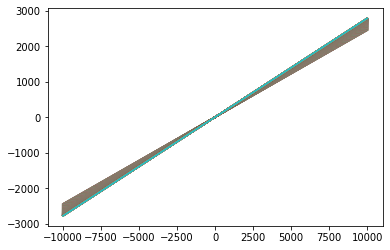

In [5]:
dist_list = np.arange(-10, 11) * 1e3

for x in range(stage_rot_num):
    plt.plot(dist_list,
             path_diff[x])
    
plt.show()

In [6]:
# Calculate the shift direction of the intersection 
slope =  np.zeros(stage_rot_num_tot)

dist_list = np.arange(-10, 11) * 1e3

# Slope through the origin

for idx in range(stage_rot_num_tot):
    slope[idx] = np.dot(path_holder[idx, :],
                        dist_list) / np.dot(dist_list,dist_list)

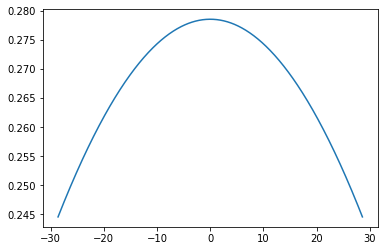

In [7]:
plt.plot(np.rad2deg(stage_rot_angles), slope)
plt.show()

# Theoretical value

In [8]:
theta = bragg
alpha = asy_angle

coef = np.cos(bragg - asy_angle) * np.tan(theta) - np.sin(theta - asy_angle)
coef *= 1 - np.cos(2 * theta)
coef_1 = coef /( np.sin(theta + alpha) * np.tan(theta))

In [9]:
coef = 4 * np.sin(alpha) * np.sin(theta) / np.sin(theta + alpha)

In [10]:
slope[300] - coef

5.611296083063433e-06

In [11]:
(slope[300] - coef) / coef

2.0146474091871944e-05

In [12]:
coef

0.2785249695542159

In [13]:
2* coef_1

0.27852496955421596

# Angular difference

In [14]:
position_holder_diff = position_holder - intersect_var[-3][np.newaxis, np.newaxis, :]

In [15]:
# Calculate the shift direction of the intersection 
slope_angle =  np.zeros(stage_rot_num_tot)
# Slope through the origin

for idx in range(stage_rot_num_tot):
    slope_angle[idx] = np.dot(position_holder_diff[idx, :, 1],
                        position_holder_diff[idx, :, 2]) / np.dot(position_holder_diff[idx, :, 2], 
                                                                  position_holder_diff[idx, :, 2])

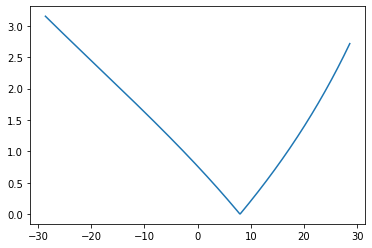

In [16]:
angle_test = np.arctan(kout_var[9, 1] / kout_var[9,2])


plt.plot(np.rad2deg(stage_rot_angles), 1e6 * np.abs(np.arctan(slope_angle) - angle_test))
plt.show()

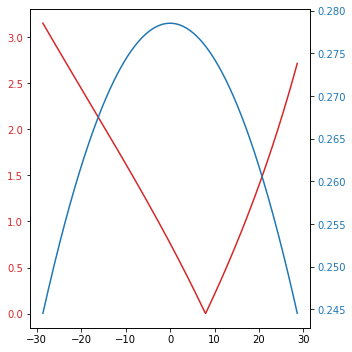

In [17]:
fig, ax1 = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(5)

color = 'tab:red'
#ax1.set_xlabel('time (s)')
#ax1.set_ylabel('exp', color=color)
ax1.plot(np.rad2deg(stage_rot_angles), 1e6 * np.abs(np.arctan(slope_angle) - angle_test), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
#ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(np.rad2deg(stage_rot_angles), slope, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

fig.savefig('C:/Users/haoyuan/Desktop/shift.png', bbox_inches='tight', pad_inches=0, dpi=600)

plt.show()

In [18]:
1 / np.sin(bragg)

3.097195578755357

In [19]:
idx = np.argmin(np.abs(np.arctan(slope_angle) - angle_test))

In [20]:
90 - np.rad2deg(stage_rot_angles[idx])

81.9848338675703

In [21]:
coef * 3 * 1e4 * np.sin(bragg) / util.c / 1000 #ps

8.999037396609628

In [22]:
6 * np.sin(bragg)

1.9372363957755512

In [23]:
slope[300] * 6 * 1e4 * np.sin(bragg) / util.c / 1000 #ps

17.99843739096678

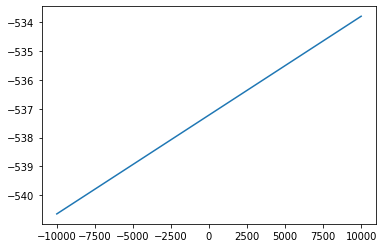

In [24]:
dist_list = np.arange(-10, 11) * 1e3

plt.plot(dist_list, position_holder[idx, :, 1] - intersect_var[-2][1])
    
plt.show()

In [25]:
idx

384

In [38]:
4 * np.sin(bragg) * np.sin(asy_angle) / np.sin(asy_angle + bragg) * (4*1e4 * np.sin(bragg)) / util.c / 1000

11.998716528812837

In [35]:
np.rad2deg(dtheta)

0.007103771200226657

In [36]:
5*1e4 * np.sin(bragg)

16143.636631462927

In [39]:
5*10 * np.sin(bragg)

16.143636631462925